In [0]:
from keras import models
from keras import layers
from keras import optimizers

In [47]:
!git clone https://github.com/alejandrotaboada/TP-DH-DeepLearning.git

fatal: destination path 'TP-DH-DeepLearning' already exists and is not an empty directory.


In [4]:
cd TP-DH-DeepLearning/
!unzip dataset.zip

/content/TP-DH-DeepLearning


In [32]:
import numpy as np
import keras
keras.__version__

'2.2.4'

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [34]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = os.getcwd()

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

Esto es lo que obtenemos:

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Vemos que la base convolucional de VGG16 tiene 14,714,688 parametros y el clasificador que estamos agregando tiene 2 millones mas.

Antes de compilar y entrenar el modelo es importante "Congelar" los pesos de la base convolucional para evitar que se actualicen durante el entrenamiento.

En Keras, para congelar una red se configura el atributo `trainable` en `False`:

In [38]:
print('Este es el número de tensores de pesos entrenables antes de freezar la base convolucional:', len(model.trainable_weights))

Este es el número de tensores de pesos entrenables antes de freezar la base convolucional: 30


In [0]:
conv_base.trainable = False

In [40]:
print('Este es el número de tensores de pesos entrenables después de freezar la base convolucional:', len(model.trainable_weights))

Este es el número de tensores de pesos entrenables después de freezar la base convolucional: 4


In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Ahora podemos comenzar a entrenar nuestro modelo, con la misma configuración de data augmentation que utilizamos en nuestro ejemplo anterior:

In [43]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# ¡Notar que la data de validación no debe ser aumentada!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Directorio target
        train_dir,
        # Reescalamos a 150x150
        target_size=(150, 150),
        batch_size=10,
        # Usamos binary_crossentropy y etiquetas binarias
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='categorical')

model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 13s 135ms/step - loss: 0.3066 - acc: 0.9210 - val_loss: 0.1375 - val_acc: 0.9740
Epoch 2/20
100/100 [==============================] - 12s 123ms/step - loss: 0.2350 - acc: 0.9320 - val_loss: 0.1005 - val_acc: 0.9760
Epoch 3/20
100/100 [==============================] - 12s 123ms/step - loss: 0.1820 - acc: 0.9480 - val_loss: 0.0628 - val_acc: 0.9880
Epoch 4/20
100/100 [==============================] - 12s 122ms/step - loss: 0.1584 - acc: 0.9480 - val_loss: 0.0441 - val_acc: 0.9880
Epoch 5/20
100/100 [==============================] - 12s 122ms/step - loss: 0.1324 - acc: 0.9710 - val_loss: 0.0534 - val_acc: 0.9880
Epoch 6/20
100/100 [==============================] - 12s 122ms/step - loss: 0.1129 - acc: 0.9620 - val_loss: 0.0309 - val_acc: 0.9880
Epoch 7/20
100/100 [==============================] - 12s 122ms/step - loss: 0.1156 - acc: 0.9680 - val_loss:

In [0]:
model.save('cats_and_dogs_small_3.h5')

Ploteamos el resultado del entrenamiento:

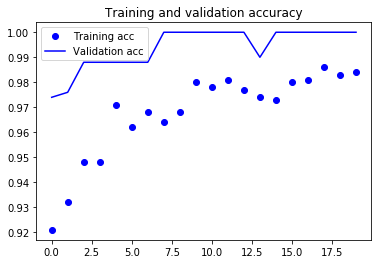

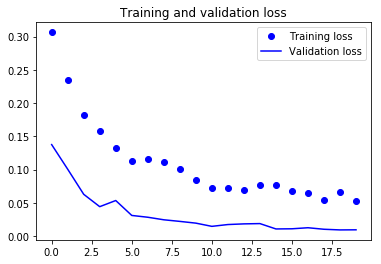

In [44]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Vemos que la accuracy en el dataset de validacion llego al 96%.

## Fine-tuning


Estos son los pasos que vamos a seguir:

1) Agregar la red personalizada sobre una red base ya entrenada.

2) Congelar la red base.

3) Entrenar la parte que nueva.

4) Descongelar algunas capas en la red base.

5) Entrenar conjuntamente estas capas y la parte que nueva.

Hemos completado los primeros 3 pasos cuando realizamos feature extraction.
Avancemos con el 4º paso: descongelaremos nuestra conv_base y luego congelaremos capas individuales dentro de ella.


Vamos a hace fine tuning de las ultimas 3 capas convolucionales. Esto significa que de la capa `block5_conv1` van a tener que estar marcadas como entrenables.

In [28]:
# Antes de modificar el atributo trainable
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [30]:
# Después de modificar el atributo trainable
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


Entrenamos el modelo con un learning rate menos para evitar que se danen las representaciones:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 208ms/step - loss: 0.2970 - acc: 0.8690 - val_loss: 0.2272 - val_acc: 0.9060
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2438 - acc: 0.8970 - val_loss: 0.2642 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 18s 178ms/step - loss: 0.2370 - acc: 0.8985 - val_loss: 0.2184 - val_acc: 0.9070
Epoch 4/100
100/100 [==============================] - 19s 188ms/step - loss: 0.2300 - acc: 0.9035 - val_loss: 0.2057 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2066 - acc: 0.9155 - val_loss: 0.2122 - val_acc: 0.9240
Epoch 6/100
100/100 [==============================] - 18s 176ms/step - loss: 0.1913 - acc: 0.9125 - val_loss: 0.1911 - val_acc: 0.9220
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 0.1667 - acc: 0.9305 - val_loss: 0.2292 - val_acc: 0.9220
Epoch 8/100
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_4.h5')

Volvemos a plotear:

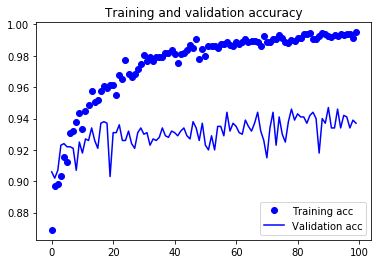

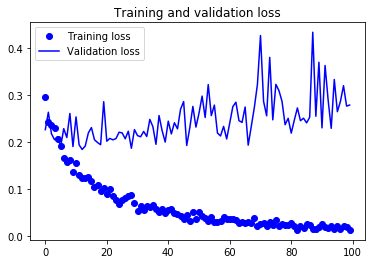

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Para que las curvas sean mas legibles, vamos a aplicar un suavizado exponencial:

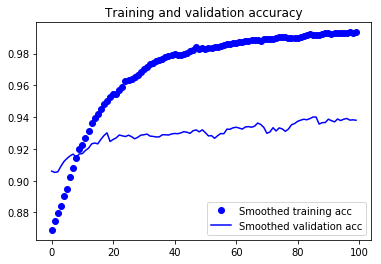

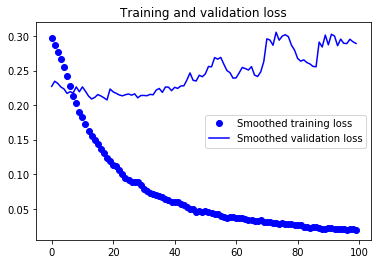

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Ahora podemos finalmente evaluar este modelo en los datos de prueba:

In [45]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 80 images belonging to 2 classes.
test acc: 0.9129999923706055


In [0]:
dir = train_dir + '/cats/'
dir

'/Users/alejandrotaboada/Desktop/Pruebas Python/train/cats/'

In [0]:
len([name for name in os.listdir(dir)])

80